In [1]:
# !pip install wandb
# !pip install transformers
# !pip install sentencepiece
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "2,3" 
import pandas as pd
import numpy as np
import re
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import math
import torch.optim as optim
import wandb
import requests
import time

wandb.login()
%env WANDB_PROJECT= Relation_Lining
# os.environ["WANDB_DISABLED"] = "true"



device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
# device = torch.device('cuda:3')

wandb: Currently logged in as: hodz199. Use `wandb login --relogin` to force relogin


env: WANDB_PROJECT=Relation_Lining


In [2]:
def get_relation_label(rel_id):
    label = ''
    API_ENDPOINT = "https://www.wikidata.org/w/api.php"
    params = {
        'action': 'wbgetentities',
        'format': 'json',
        'languages': 'en',
        'props': 'labels',
        'ids': ''
    }
      
    params['ids'] = str(rel_id)

    try:
        response = requests.get(API_ENDPOINT, params = params).json()['entities']
        label = response[str(rel_id)]['labels']['en']['value']
    except:
        return label
    return label

In [3]:
from multiprocessing import Pool
from functools import partial
import inspect
import time
import os
import requests

def parallal_task(func, iterable, *params): 
    with open(f'./tmp_func.py', 'w') as file:
        file.write("import requests \n")
        file.write(inspect.getsource(func).replace(func.__name__, 'task'))

    from tmp_func import task
    pool = Pool(processes=15)
    res = pool.map(task, iterable)
    pool.close()
    
    os.remove('./tmp_func.py')
    return res

In [4]:
# Create torch dataset
# https://towardsdatascience.com/fine-tuning-pretrained-nlp-models-with-huggingfaces-trainer-6326a4456e7b

class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels['input_ids'][idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

In [5]:
max_source_length = 4048
max_target_length = 128

In [6]:
from transformers import T5TokenizerFast, T5ForConditionalGeneration 
from transformers import EarlyStoppingCallback

tokenizer = T5TokenizerFast.from_pretrained("t5-base")
model = T5ForConditionalGeneration.from_pretrained("t5-base").to(device)

In [7]:
training_data = pd.read_csv('./3-Relation_Linking_Data/1-csv_format/training_data.csv')
training_data = training_data.dropna()
training_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31090 entries, 0 to 31226
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   question               31090 non-null  object
 1   entity label           31090 non-null  object
 2   relation labels        31090 non-null  object
 3   target relation id     31090 non-null  object
 4   target relation label  31090 non-null  object
dtypes: object(5)
memory usage: 1.4+ MB


In [8]:
# start = time.time()
# training_data['target relation label'] = parallal_task(get_relation_label, list(training_data['target relation id']))
# print(time.time() - start)
# training_data.to_csv('./3-Relation_Linking_Data/1-csv_format/training_data.csv', index=False)

In [9]:
training_data['input_text'] = '**' + training_data['question'] + '**,**' + training_data['relation labels'] + '**'

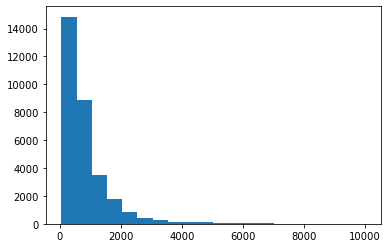

In [10]:
import matplotlib.pyplot as plt
plt.hist(training_data['input_text'].str.len(), bins = 20)
plt.show()

In [11]:
len(training_data['input_text'][training_data['input_text'].str.len() > 1800])*100/len(training_data['input_text'])

8.842071405596656

In [12]:
len(training_data[training_data['input_text'].str.len() <= 4048])/len(training_data)

0.9865551624316501

In [13]:
training_data = training_data[training_data['input_text'].str.len() <= 2024]
training_data = training_data.sample(frac=1, random_state=1)
training_data

,question,entity label,relation labels,target relation id,target relation label,input_text
273,whats the genre for the book titled shadows in...,shadows in flight,"[ instance of , author , publisher , part o...",P136,genre,**whats the genre for the book titled shadows ...
8921,what is a gameplay feature on gp-1: part ii,gp-1: part ii,"[ instance of , genre , game mode , publish...",P404,game mode,**what is a gameplay feature on gp-1: part ii*...
15084,what language is spoken on the tv show coal,coal,"[ instance of , country of origin , producti...",P364,original language of film or TV show,**what language is spoken on the tv show coal*...
6269,what kind of european is pedro sempson,pedro sempson,"[ date of birth , instance of , given name ,...",P27,country of citizenship,"**what kind of european is pedro sempson**,**[..."
13526,what is the genre of the album this is our music,this is our music,"[ performer , record label , instance of , ...",P136,genre,**what is the genre of the album this is our m...
...,...,...,...,...,...,...
11846,what types of game is jade empire,jade empire,"[ instance of , game mode , platform , publ...",P136,genre,"**what types of game is jade empire**,**[ inst..."
18668,What is Efim Geller's gender?,Efim Geller,"[ sex or gender , VIAF ID , ISNI , Commons ...",P21,sex or gender,"**What is Efim Geller's gender?**,**[ sex or g..."
5625,Where did hughie thomasson die,hughie thomasson,"[ sex or gender , occupation , MusicBrainz a...",P20,place of death,"**Where did hughie thomasson die**,**[ sex or ..."
13152,what is the sequel to sleepaway camp,sleepaway camp,"[ IMDb ID , instance of , director , cast m...",P156,followed by,"**what is the sequel to sleepaway camp**,**[ I..."


In [14]:
input_text = list(training_data['input_text'])
input_text[0]

'**whats the genre for the book titled shadows in flight**,**[ instance of ,  author ,  publisher ,  part of the series ,  OCLC control number ,  ISBN-13 ,  genre ,  characters ,  Freebase ID ,  country of origin ,  publication date ,  language of work or name ,  ISFDB title ID ,  NooSFere book ID ,  title ,  OCLC work ID ,  place of publication ,  takes place in fictional universe ,  Goodreads version/edition ID ,  Goodreads work ID ,  cover art by ,  form of creative work ,  follows ,  FantLab work ID ,  set in environment ,  Open Library ID ]**'

In [15]:
target_text = list(training_data['target relation label'].astype(str))
target_text[0]

'genre'

In [16]:
X_train_tokenized = tokenizer(['relation_linking: ' + sequence for sequence in input_text], 
                              padding=True, 
                              truncation=True, 
                              max_length=max_source_length)

y_train_tokenized = tokenizer(target_text, 
                              padding=True, 
                              truncation=True, 
                              max_length=max_target_length)

print(len(training_data))
# print(len(training_sample))

28944


In [17]:
validation_data = pd.read_csv('./3-Relation_Linking_Data/1-csv_format/validation_data.csv')
validation_data
print(len(validation_data))
validation_data = validation_data.dropna()

4423


In [18]:
# start = time.time()
# validation_data['target relation label'] = parallal_task(get_relation_label, list(validation_data['target relation id']))
# print(time.time() - start)
# validation_data.to_csv('./3-Relation_Linking_Data/1-csv_format/validation_data.csv', index=False)

In [19]:
validation_data['input_text'] = '**' + validation_data['question'] + '**,**' + validation_data['relation labels'] + '**'
validation_data = validation_data[validation_data['input_text'].str.len() <= 1700]
validation_data = validation_data.sample(frac=1, random_state=1)

In [20]:
input_text_val = validation_data['input_text']

In [21]:
target_text_val = list(validation_data['target relation label'].astype(str))
target_text_val[0]

'genre'

In [22]:
X_val_tokenized = tokenizer(['relation_linking: ' + sequence for sequence in input_text_val], 
                              padding=True, 
                              truncation=True, 
                              max_length=max_source_length)

y_val_tokenized = tokenizer(target_text_val, 
                              padding=True, 
                              truncation=True, 
                              max_length=max_target_length)

print(len(validation_data))
# print(len(training_sample))

3976


In [23]:
train_dataset = Dataset(X_train_tokenized, y_train_tokenized)

In [24]:
val_dataset = Dataset(X_val_tokenized, y_val_tokenized)

In [25]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    "Relation_linking_without_entity_higher_patience",
    evaluation_strategy ='steps',
    eval_steps = 1000, # Evaluation and Save happens every 50 steps
    logging_steps = 1000,
    save_steps = 1000,
    save_total_limit = 5, # Only last 5 models are saved. Older ones are deleted.
    per_device_train_batch_size = 2,
    per_device_eval_batch_size = 2,
    learning_rate = 1e-3,
    adam_epsilon = 1e-8,
    num_train_epochs = 5,
    report_to="wandb",
#     metric_for_best_model = 'f1',
    load_best_model_at_end=True
)

In [26]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    model=model, 
    args=training_args, 
    train_dataset= train_dataset,
    eval_dataset = val_dataset,
#     callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
    callbacks = [EarlyStoppingCallback(early_stopping_patience=5)]
)

In [27]:
trainer.train()

/home/HadyElkady/miniconda3/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 28944
  Num Epochs = 5
  Instantaneous batch size per device = 2
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 36180
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


/home/HadyElkady/miniconda3/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss
1000,0.160700,0.071863
2000,0.058000,0.031202
3000,0.045500,0.025268
4000,0.035300,0.030116
5000,0.030500,0.024925
6000,0.032000,0.018685
7000,0.030500,0.029649
8000,0.025300,0.021034
9000,0.022800,0.016720
10000,0.019900,0.015890


***** Running Evaluation *****
  Num examples = 3976
  Batch size = 4
Saving model checkpoint to Relation_linking_without_entity_higher_patience/checkpoint-1000
Configuration saved in Relation_linking_without_entity_higher_patience/checkpoint-1000/config.json
Model weights saved in Relation_linking_without_entity_higher_patience/checkpoint-1000/pytorch_model.bin
/home/HadyElkady/miniconda3/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 3976
  Batch size = 4
Saving model checkpoint to Relation_linking_without_entity_higher_patience/checkpoint-2000
Configuration saved in Relation_linking_without_entity_higher_patience/checkpoint-2000/config.json
Model weights saved in Relation_linking_without_entity_higher_patience/checkpoint-200

Model weights saved in Relation_linking_without_entity_higher_patience/checkpoint-12000/pytorch_model.bin
Deleting older checkpoint [Relation_linking_without_entity_higher_patience/checkpoint-7000] due to args.save_total_limit
/home/HadyElkady/miniconda3/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 3976
  Batch size = 4
Saving model checkpoint to Relation_linking_without_entity_higher_patience/checkpoint-13000
Configuration saved in Relation_linking_without_entity_higher_patience/checkpoint-13000/config.json
Model weights saved in Relation_linking_without_entity_higher_patience/checkpoint-13000/pytorch_model.bin
Deleting older checkpoint [Relation_linking_without_entity_higher_patience/checkpoint-8000] due to args.save_total_

TrainOutput(global_step=22000, training_loss=0.02936964464187622, metrics={'train_runtime': 17649.8724, 'train_samples_per_second': 8.199, 'train_steps_per_second': 2.05, 'total_flos': 7.211393519616e+16, 'train_loss': 0.02936964464187622, 'epoch': 3.04})

In [28]:
print('finished')

finished
